<a href="https://colab.research.google.com/github/NataliaBlueCloud/yolo-recognition-pipeline/blob/main/Train_YOLO_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test and Train YOLO Model Example

Adapted and annotated by: Nataliia Koneva

Original source code and training workflow: Evan Juras ([EJ Technology Consultants](https://ejtech.io))

Original repository: [Train and Deploy YOLO Models](https://github.com/EdjeElectronics/Train-and-Deploy-YOLO-Models)

Last updated: January 2025


# Introduction

This Colab notebook provides a complete, step-by-step workflow for training, validating, and testing YOLOv8/v11 models directly in Google Colab. The notebook has been adapted with additional comments and clarifications to facilitate training custom object detection models (for instance, detecting coffee, sugar, and tea).

#1.&nbsp;Gather and Label Training Images

Before training begins, images need to be collected and labelled.
This dataset `dataset_drink_v2.zip` was labelled with [Label Studio](https://labelstud.io/?utm_source=youtube&utm_medium=video&utm_campaign=edjeelectronics).

Label files follow the YOLO format: each .txt file contains normalized coordinates and class IDs for each object in an image.



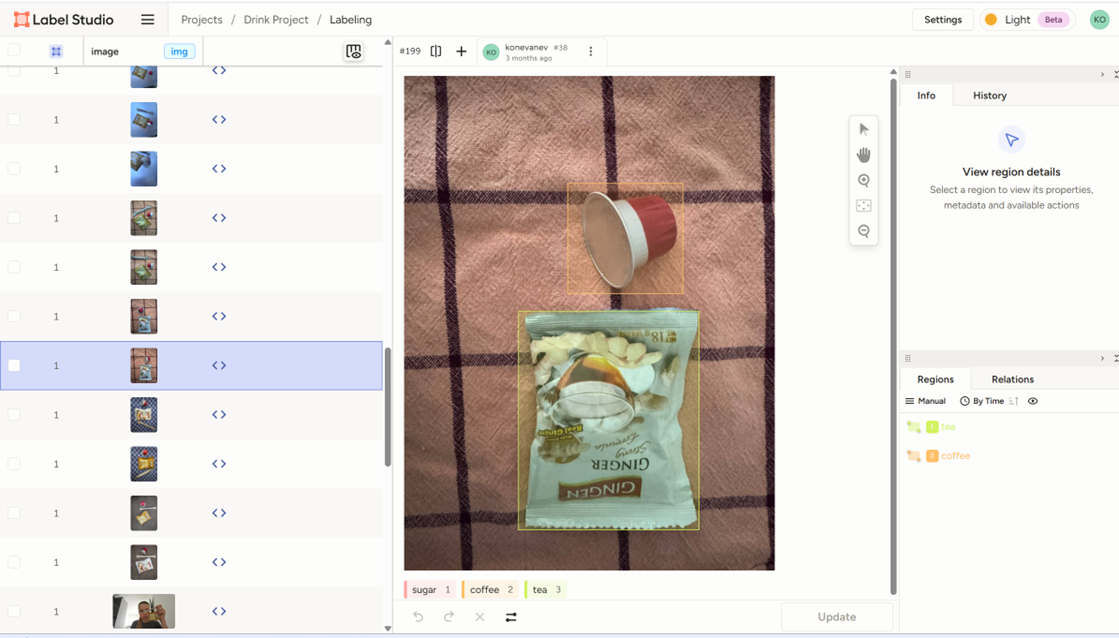<p align=center>



# 2. Split into Training and Validation Sets

Ultralytics requires a specific folder hierarchy:

data/
 ├── train/

 │    ├── images/

 │    └── labels/

 └── validation/

│        ├── images/

│        └── labels/
    

In [22]:
!unzip -q /content/dataset_drink_v2.zip -d /content/custom_data

To automate this split, Evan Juras provides a helper script:

In [23]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data/" --train_pct=0.9

--2025-11-11 18:42:18--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-11-11 18:42:19 (48.6 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 75
Number of annotation files: 75
Images moving to train: 67
Images moving to validation: 8


This script randomly assigns 90% of the data to the training folder and 10% to validation.

# 3. Install Dependencies

The model is trained using the Ultralytics library, which supports YOLOv5–v11.

In [19]:
!pip install ultralytics

# 4. Configuration file


Create a `data.yaml` Configuration File

Ultralytics requires a YAML file describing dataset paths and class names.
The following function automatically generates it based on a classes.txt file in the dataset folder:

In [24]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/custom_data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 3
names:
- coffee
- sugar
- tea


# 5. 🚀Train the Model

Now that everything is ready, we can start training.
Choose model architecture (e.g., yolo11s.pt) and adjust parameters such as epochs and image size:

During training, YOLO prints precision (P), recall (R), and mean average precision (mAP) after each epoch.
Results are saved to `/content/runs/detect/train`.

After 60 epochs, the best weights are located at:

`/content/runs/detect/train/weights/best.pt`.

In [25]:
!yolo detect train data=/content/data.yaml model=yolo11s.pt epochs=60 imgsz=640

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

Example Results
**Текст, выделенный полужирным шрифтом**
After 60 epochs, the model achieved high precision and recall on the validation set:

| Class  | Precision | Recall | mAP@50 | mAP@50–95 |
|:-------|:-----------|:--------|:--------|:-----------|
| **coffee** | 0.99 | 0.92 | 0.99 | 0.72 |
| **sugar**  | 0.97 | 1.00 | 0.99 | 0.69 |
| **tea**    | 0.96 | 1.00 | 0.99 | 0.88 |


These metrics indicate a robust model for small object categories with limited data.

#6. Validation the Trained Model

To test your trained model on validation data or new images:

In [26]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=data/validation/images save=True

Ultralytics 8.3.227 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/8 /content/data/validation/images/100d2a5b-photo_2025-08-07_13-47-55.jpg: 640x480 1 sugar, 1 tea, 77.7ms
image 2/8 /content/data/validation/images/23d82f42-photo_2025-08-07_13-50-31.jpg: 640x480 1 coffee, 3 sugars, 1 tea, 15.0ms
image 3/8 /content/data/validation/images/48cbafd2-photo_2025-08-07_13-48-29.jpg: 640x480 1 coffee, 1 sugar, 1 tea, 12.4ms
image 4/8 /content/data/validation/images/4daf5273-photo_2025-08-07_13-50-52.jpg: 640x480 1 coffee, 1 sugar, 1 tea, 13.1ms
image 5/8 /content/data/validation/images/5e0f8c9d-photo_2025-08-07_13-50-44.jpg: 640x480 1 coffee, 1 tea, 14.9ms
image 6/8 /content/data/validation/images/61cf9daa-photo_2025-08-07_13-48-05.jpg: 640x480 1 coffee, 12.3ms
image 7/8 /content/data/validation/images/e2d5be3f-WIN_20250807_13_26_34_Pro.jpg: 384x640 1 coffee, 85.9ms
image 8/8 /content/da

This command generates predictions with bounding boxes drawn on the detected objects.

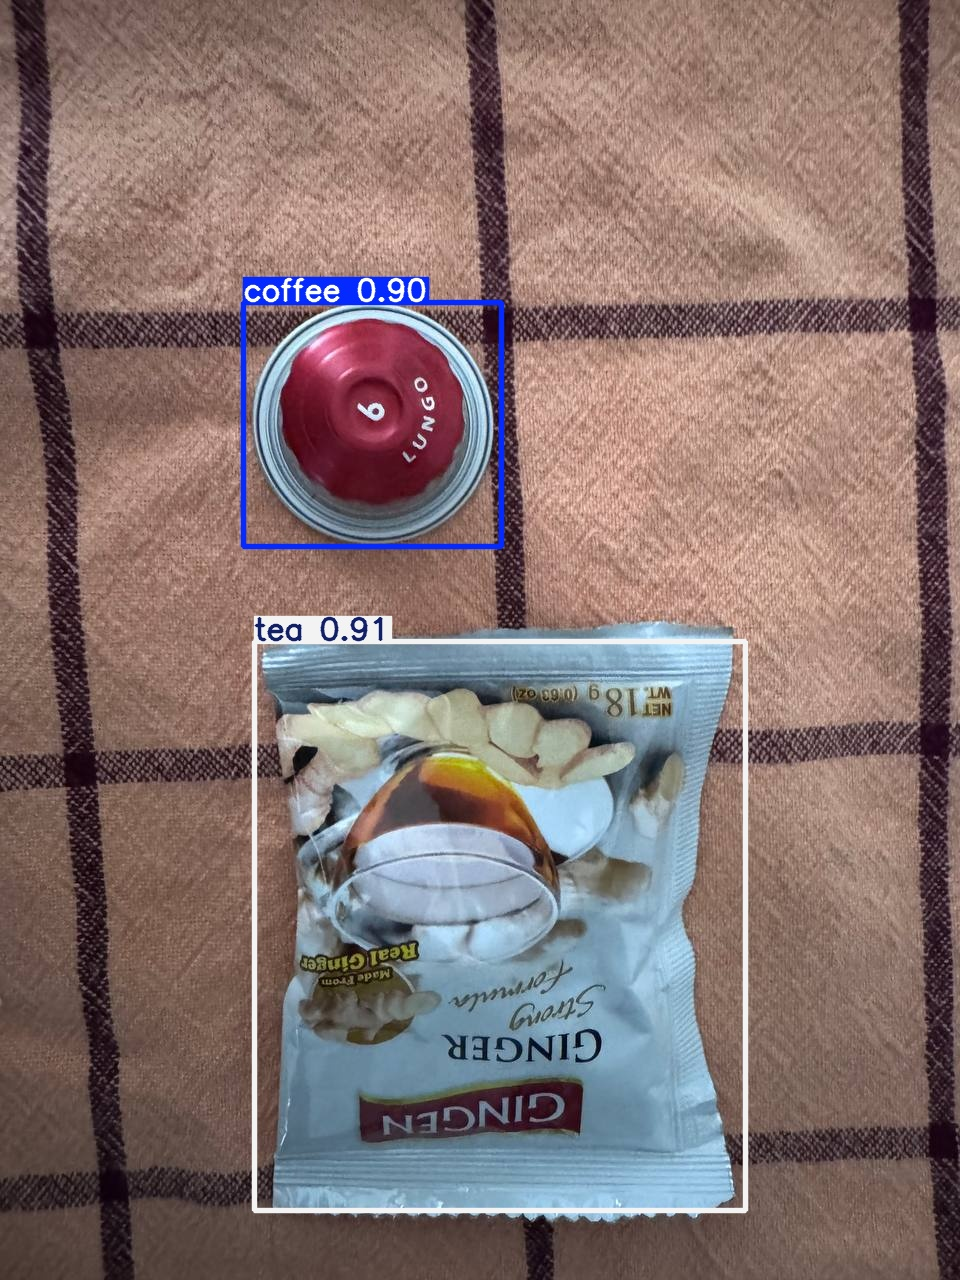

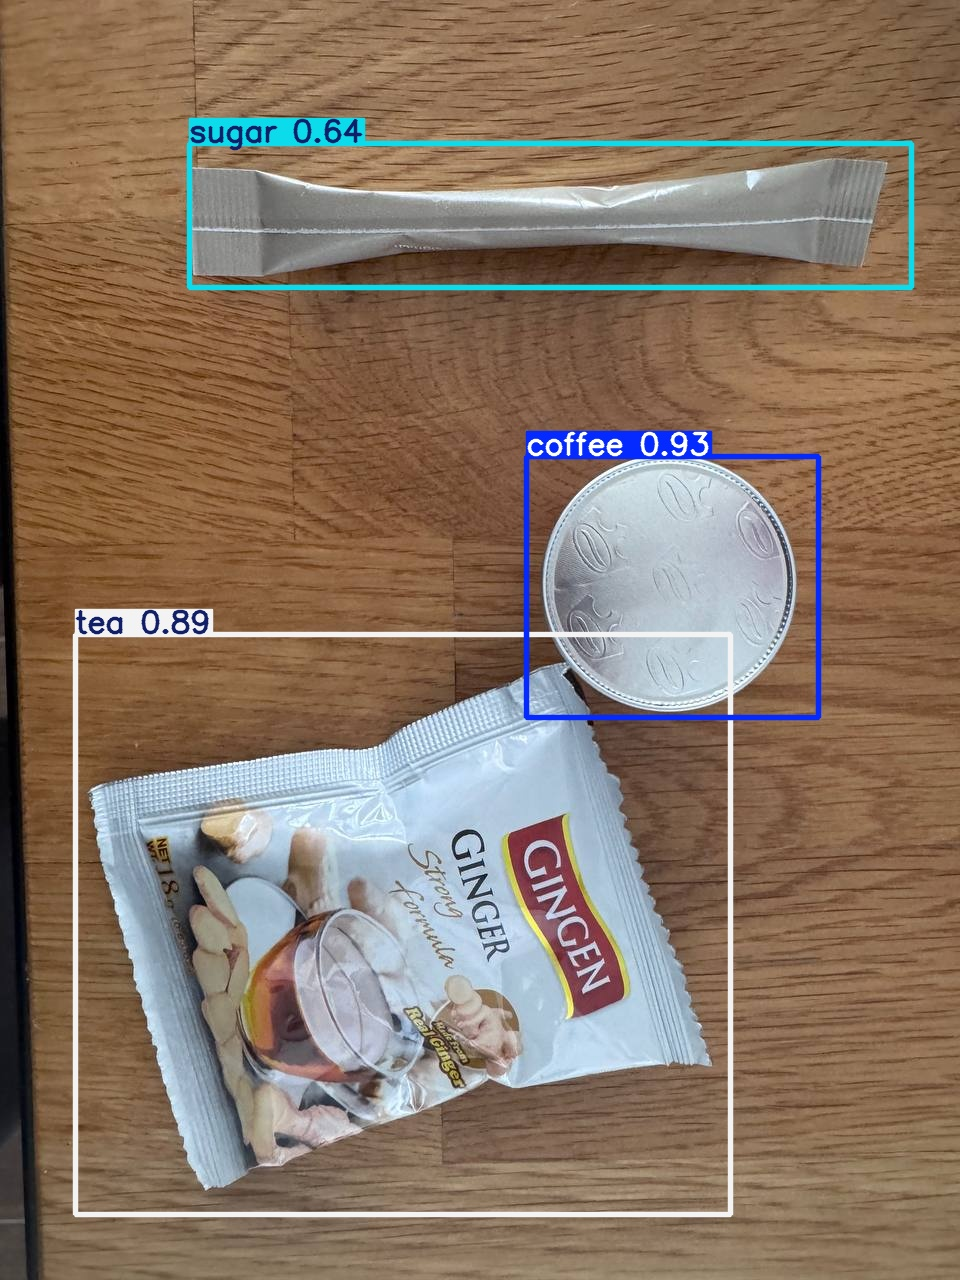

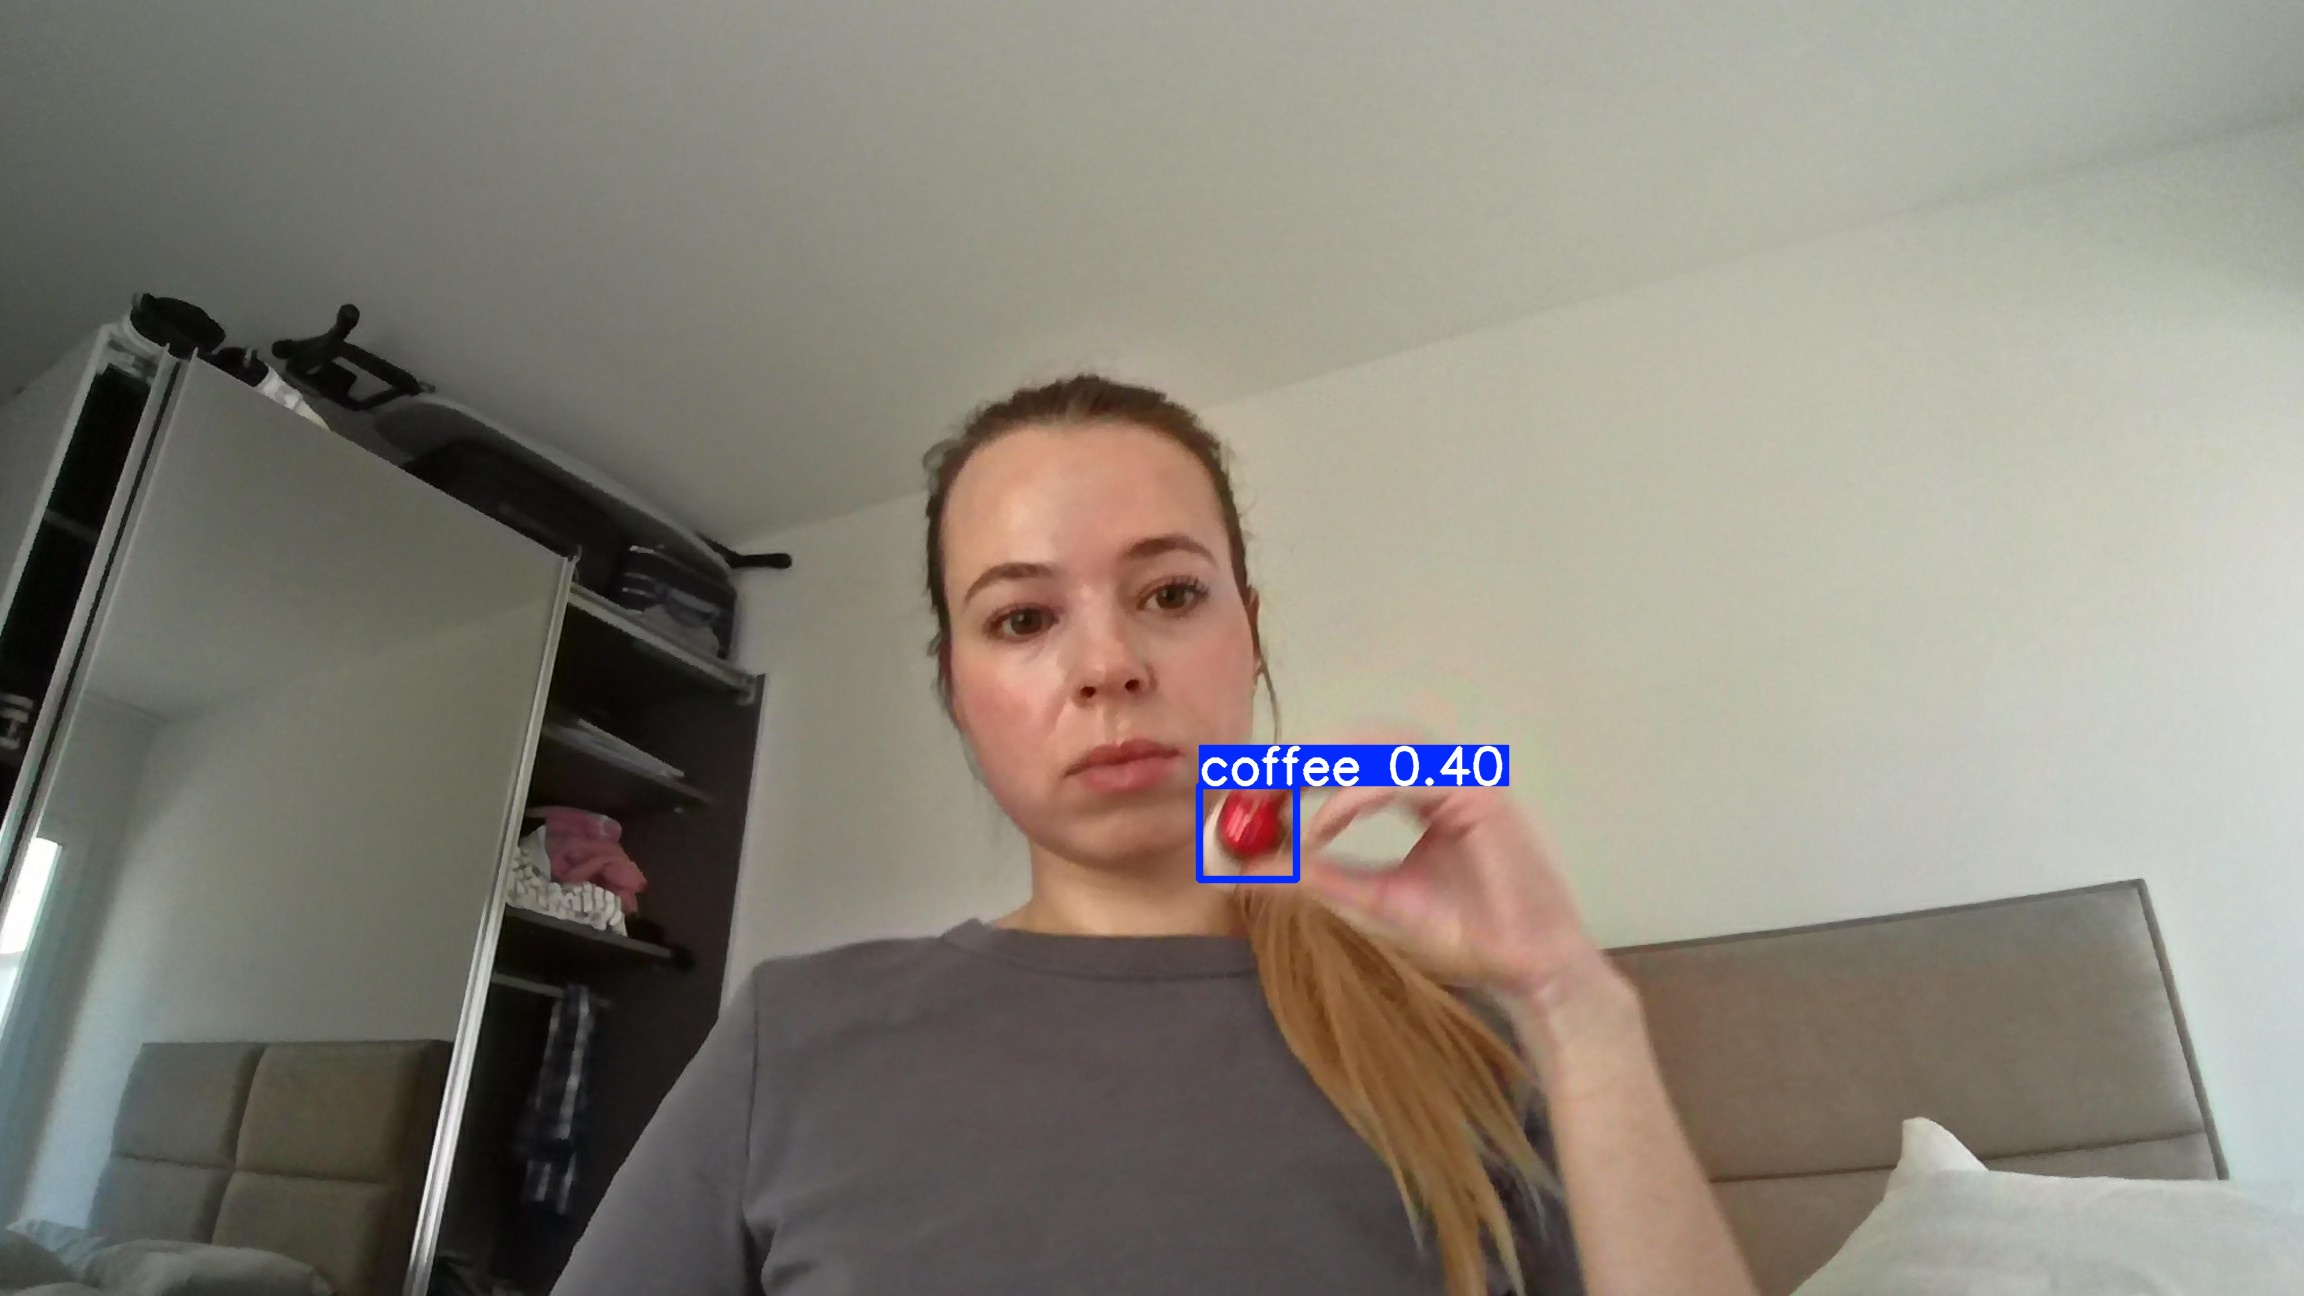

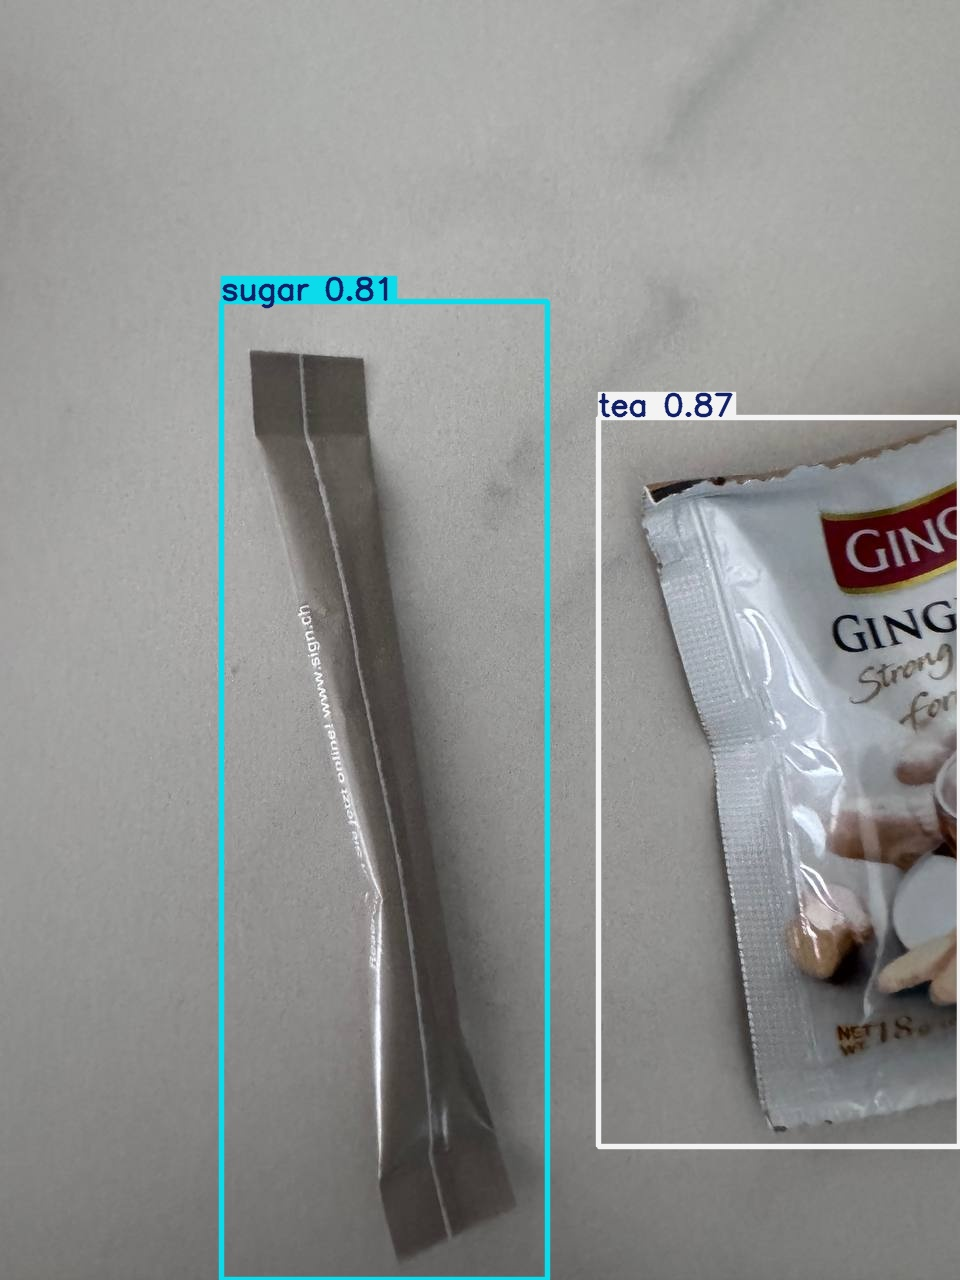

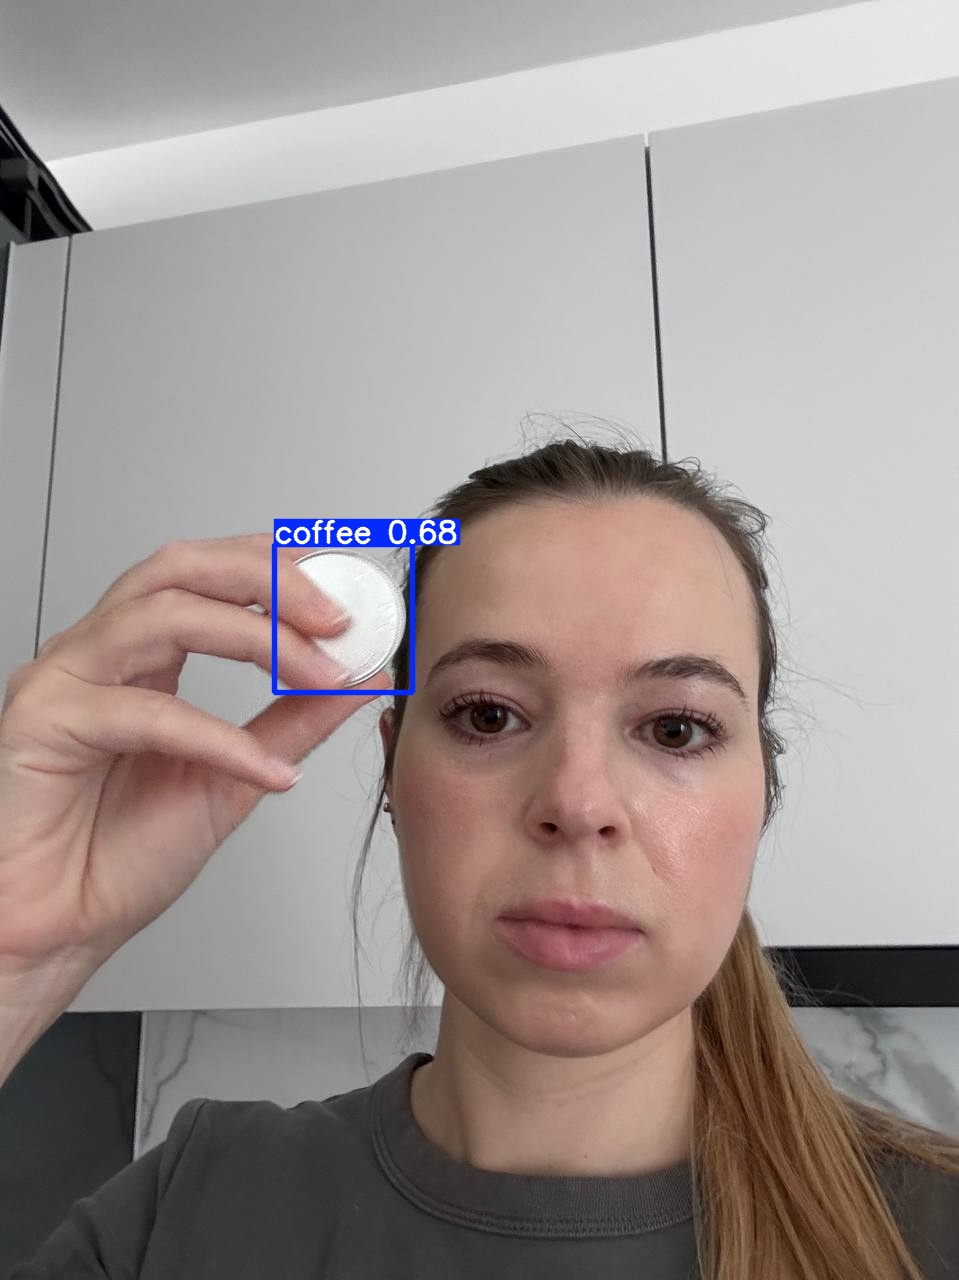

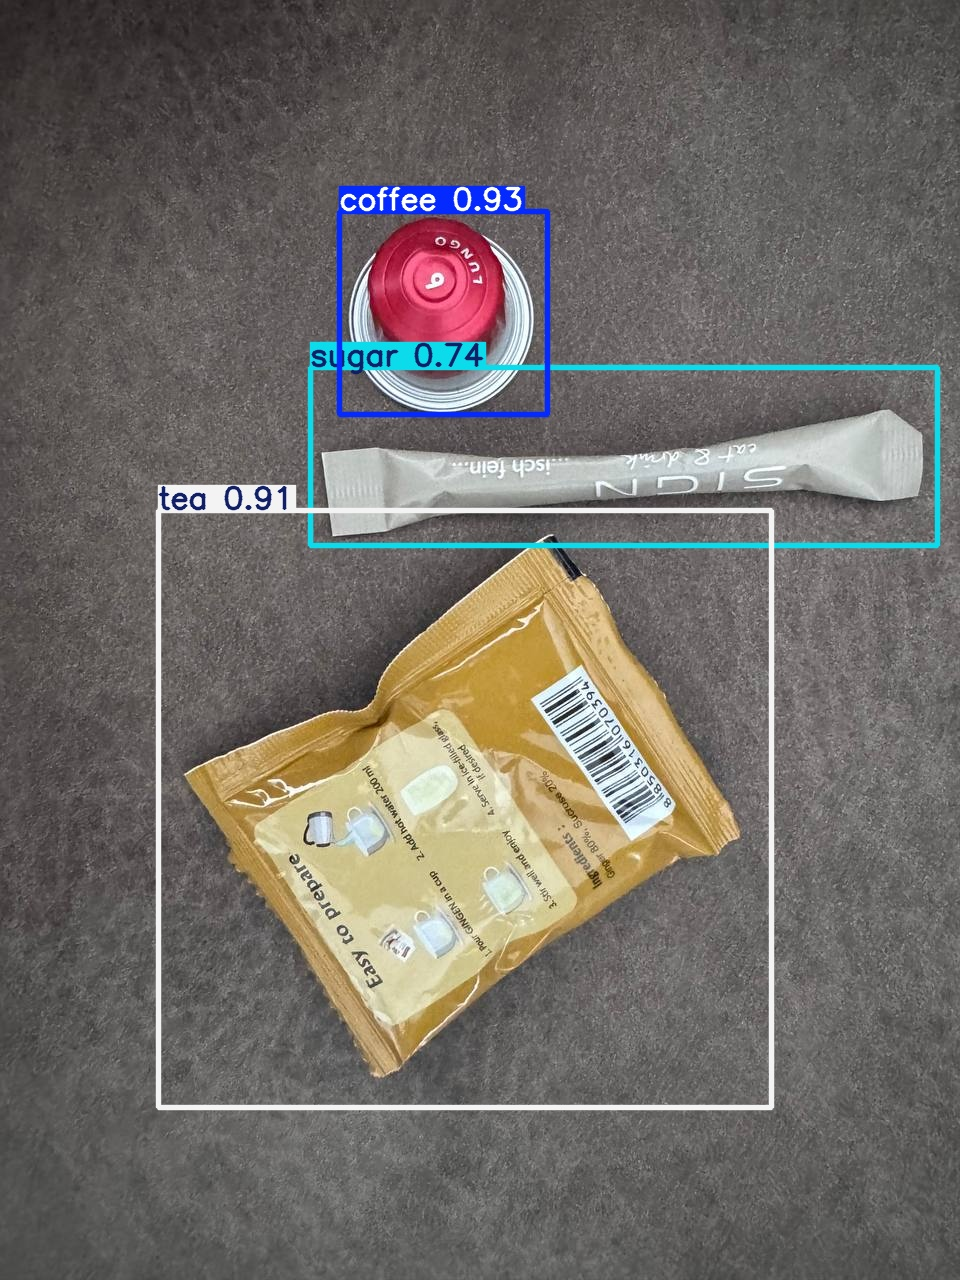

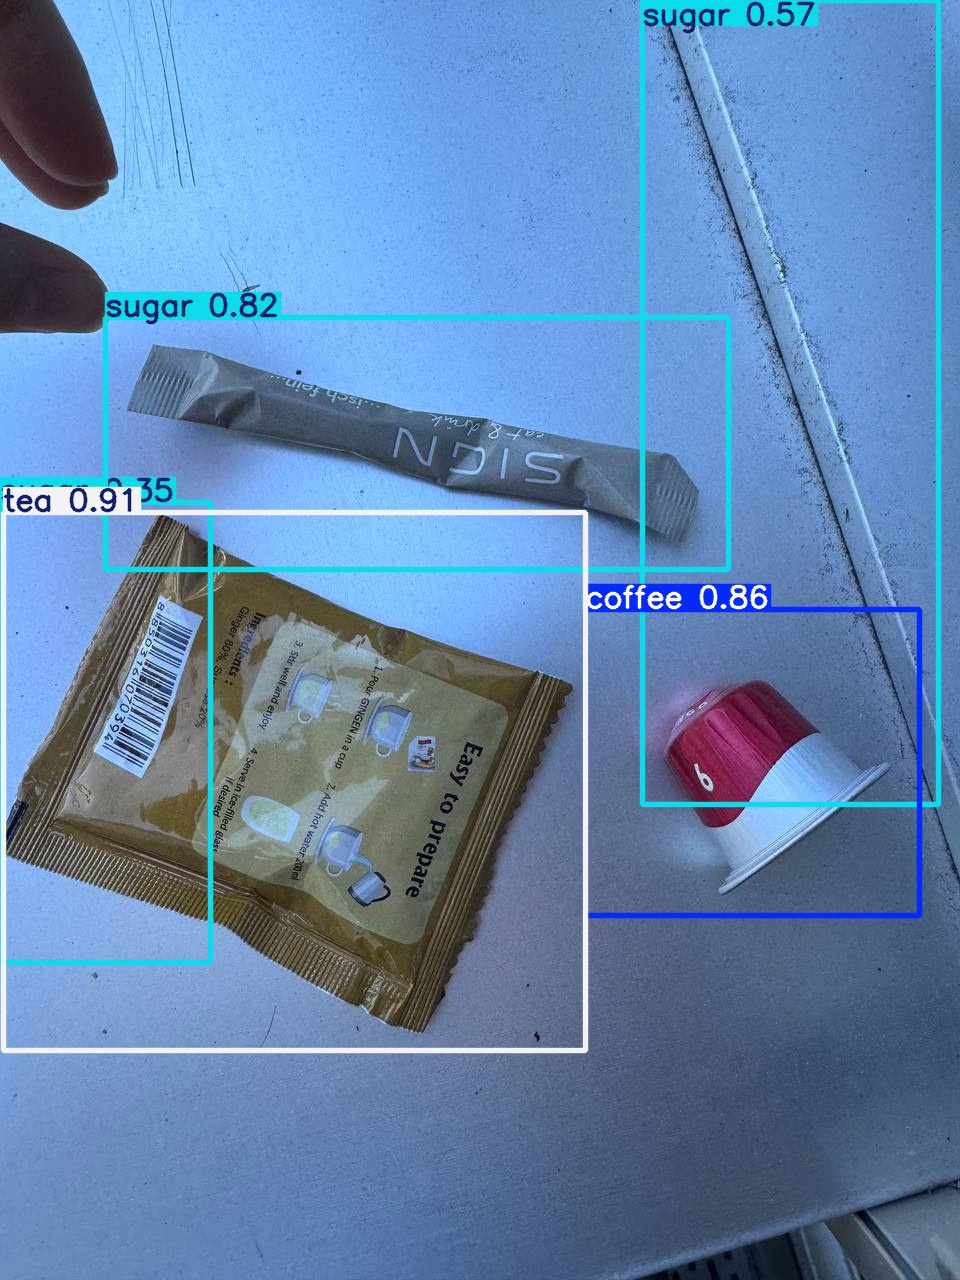

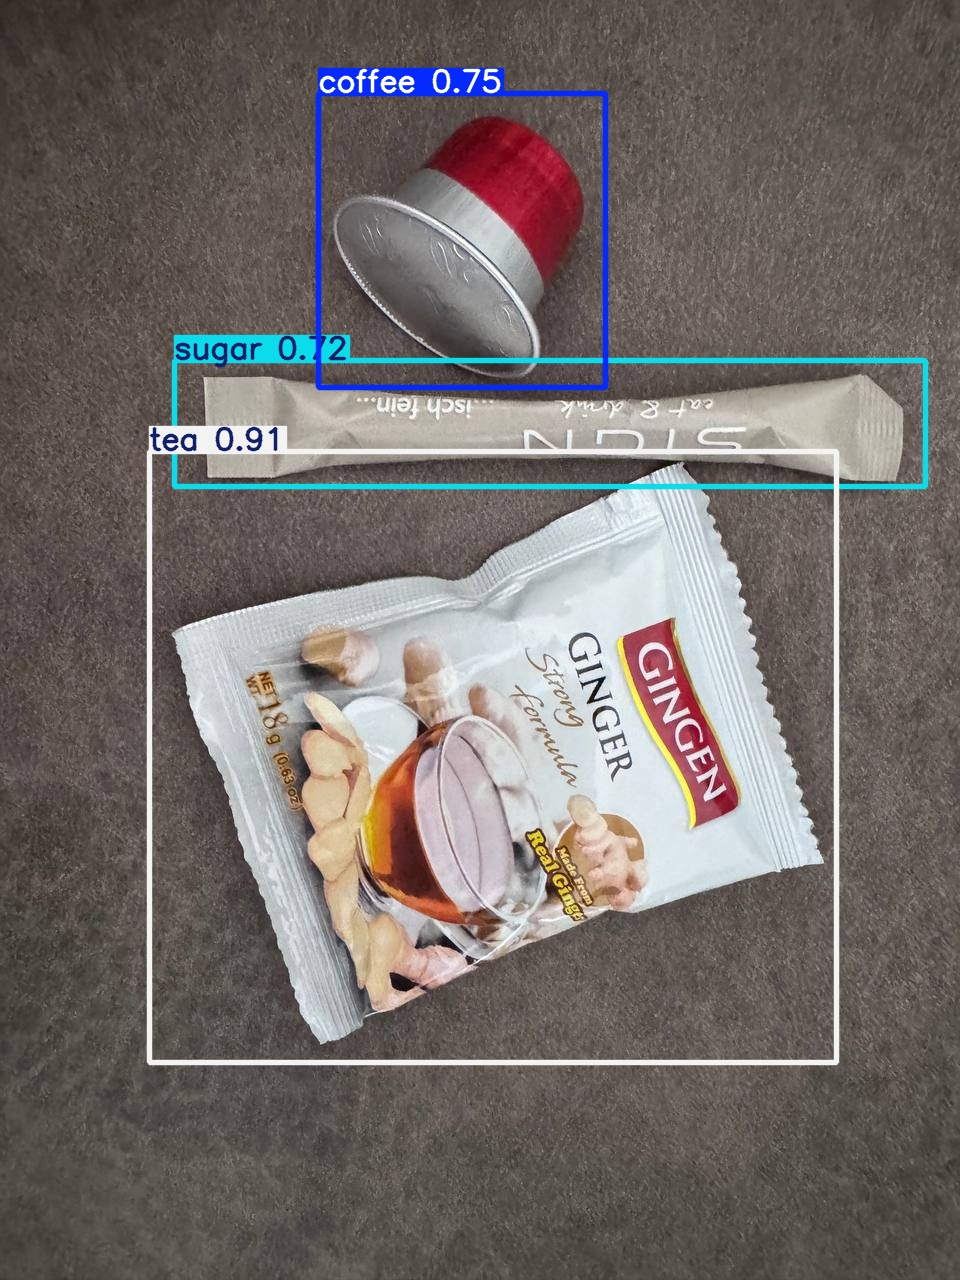

In [27]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


The model should draw a box around each object of interest in each image. If it isn't doing a good job of detecting objects, here are a few tips:

1. Double-check your dataset to make sure there are no labeling errors or conflicting examples.
2. Increase the number of epochs used for training.
3. Use a larger model size (e.g. `yolo11l.pt`).
4. Add more images to the training dataset. See my [dataset video](https://www.youtube.com/watch?v=v0ssiOY6cfg) for tips on how to capture good training images and improve accuracy.

You can also run the model on video files or other images images by uploading them to this notebook and using the above `!yolo detect predict` command, where `source` points to the location of the video file, image, or folder of images. The results will be saved in `runs/detect/predict`.

Drawing boxes on images is great, but it isn't very useful in itself. It's also not very helpful to just run this models inside a Colab notebook: it's easier if we can just run it on a local computer. Continue to the next section to see how to download your newly trained model and run it on a local device.

# 8. Export the Model

You can download your best model weights to run locally:

In [29]:
from google.colab import files
files.download('/content/runs/detect/train/weights/best.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>